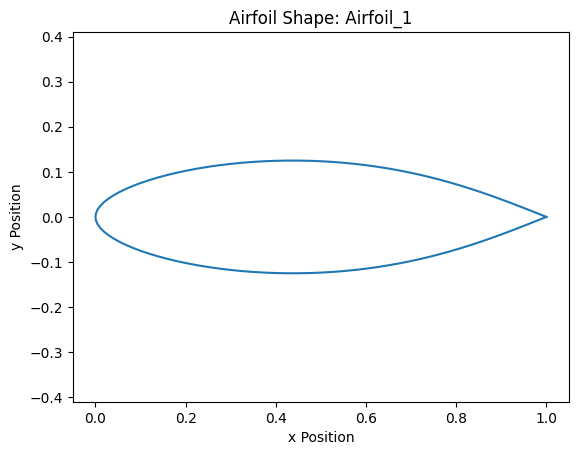

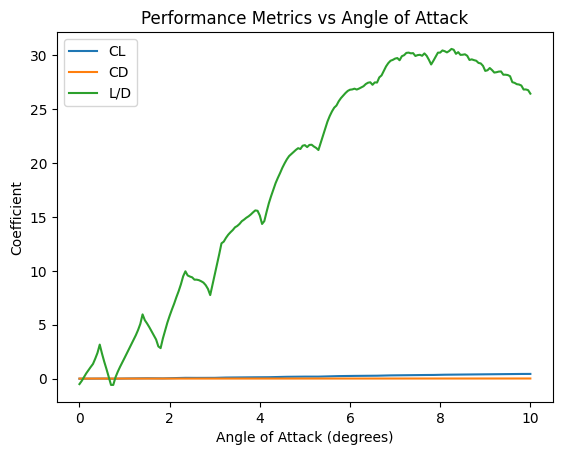

In [8]:
# import necessary libraries
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import math
import torch
from gymnasium.spaces import Discrete, Box
import torch.nn as nn
import torch.nn.functional as F
import random

# define actor-critic neural network
class ActorCriticNetwork(nn.Module):
    def __init__(self, obs_space_size, action_space_size):
        super().__init__()

        self.shared_layers = nn.Sequential(
            nn.Linear(obs_space_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )

        self.policy_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_space_size),
        )

        self.value_layers = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
        )

    def value(self, obs):
        z = self.shared_layers(obs)
        value = self.value_layers(z)
        return value
    
    def policy(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        return policy_logits
    
    def forward(self, obs):
        z = self.shared_layers(obs)
        policy_logits = self.policy_layers(z)
        value = self.value_layers(z)
        return policy_logits, value

# creating XFOIL environment
class XFOILEnv:
    def __init__(self):
        self.action_space = Discrete(5)  


def bezierCurve(foil_name, yu, yl):
    
    xl = np.linspace(0,1,num=len(yl))
    xl[1] = 0.0
    xu = xl[::-1]
    
    
    t = sym.Symbol('t')
    n = len(yu)-1

    Bxu = 0
    Byu = 0
    Bxl = 0
    Byl = 0

    dt = np.linspace(0,1,num=50)

    for i in range(n+1):
        c = math.factorial(n)/(math.factorial(i)*math.factorial(n-i))
        Bxu += c * (t ** i) * ((1 - t)**(n - i)) * xu[i]
        Byu += c * (t ** i) * ((1 - t)**(n - i)) * yu[i]
        Bxl += c * (t ** i) * ((1 - t)**(n - i)) * xl[i]
        Byl += c * (t ** i) * ((1 - t)**(n - i)) * yl[i]

    Pxu = []
    Pyu = []
    Pxl = []
    Pyl = []

    for i in range(len(dt)):
        Pxu.append(Bxu.subs(t,dt[i]))
        Pyu.append(Byu.subs(t,dt[i]))
        Pxl.append(Bxl.subs(t,dt[i]))
        Pyl.append(Byl.subs(t,dt[i]))

    with open(f"{foil_name}.dat","w") as file:

        file.write(f"{foil_name}\n")
        for i in range(len(dt)):
            file.write(f"{Pxu[i]:.5f} {Pyu[i]:.5f}\n")

        for i in range(len(dt)):
            file.write(f"{Pxl[i]:.5f} {Pyl[i]:.5f}\n")


def simulate_airfoil(foil_name, ai, af, da, Re, nmax):
    
    # XFOIL input file writer 
    if os.path.exists("polar_file.txt"):
        os.remove("polar_file.txt")
        
    input_file = open("input_file.in", 'w')
    input_file.write("LOAD {0}.dat\n".format(foil_name))
    input_file.write(foil_name + '\n')
    input_file.write("PANE\n")
    input_file.write("OPER\n")
    input_file.write("Visc {0}\n".format(Re))
    input_file.write("PACC\n")
    input_file.write("polar_file.txt\n\n")
    input_file.write("ITER {0}\n".format(nmax))
    input_file.write("ASeq {0} {1} {2}\n".format(ai, af, da))
    input_file.write("\n\n")
    input_file.write("quit\n")
    input_file.close()
    subprocess.call("xfoil.exe < input_file.in", shell=True)
    polar_data = np.loadtxt("polar_file.txt", skiprows=12)

    # Display the airfoil shape
    plt.figure()
    plt.title("Airfoil Shape: {0}".format(foil_name))
    plt.xlabel("x Position")
    plt.ylabel("y Position")
    plt.axis("equal")
    airfoil_data = np.loadtxt("{0}.dat".format(foil_name), skiprows=1)
    plt.plot(airfoil_data[:,0], airfoil_data[:,1])

    # Display performance metrics
    plt.figure()
    plt.title("Performance Metrics vs Angle of Attack")
    plt.xlabel("Angle of Attack (degrees)")
    plt.ylabel("Coefficient")
    plt.plot(polar_data[:,0], polar_data[:,1], label='CL')
    plt.plot(polar_data[:,0], polar_data[:,2], label='CD')
    plt.plot(polar_data[:,0], polar_data[:,1]/polar_data[:,2], label='L/D')
    plt.legend()
    plt.show()


# inputs
foil_name = "Airfoil_1"
ai = 0
af = 10
da = 0.05
Re = 1000000
nmax = 100
yl = [0.0,-0.1,-0.2,-0.1,0.0]
yu = [0.0,0.1,0.2,0.1,0.0]
bezierCurve(foil_name, yu, yl)
simulate_airfoil(foil_name, ai, af, da, Re, nmax)